In [1]:
import os
import pickle
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from openretina.hoefling_2024.configs import model_config, trainer_config
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=40)

from scipy.stats import pearsonr as lincorr

from functools import partial

import sys
sys.path.append('/gpfs01/euler/User/lhoefling/GitHub/nnfabrik_euler')

In [3]:
from rgc_natstim_model.utils.inference import get_model_responses
from rgc_natstim_model.utils.data_handling import convert_nested_dict_to_dataframe

In [4]:
from rgc_natstim_model.analyses.eval import calculate_correlations, calculate_nat_reliability_index

# Import constants

In [5]:
from rgc_natstim_model.constants.identifiers import dh2eh, dh2eh_linear, example_nids

# Load data from file

# load dataset

In [7]:
with open(r'/gpfs01/euler/User/lhoefling/Data/rebuttal/cleaned_df_230906.pkl', "rb") as f:
    df = pickle.load(f)

In [8]:
with open(r'/gpfs01/euler/User/lhoefling/Data/rebuttal/full_df_230906.pkl', "rb") as f:
    full_df = pickle.load(f)

In [15]:
#with open(r'/gpfs01/euler/User/lhoefling/Data/5e620609fc7b491aa5edb4a5d4cd7276.pkl', "wb") as f:
#    pkl.dump(full_df[full_df["dataset_hash"] == '5e620609fc7b491aa5edb4a5d4cd7276'], f)

In [9]:
#with open(r'/gpfs01/euler/User/lhoefling/Data/rebuttal/gradient_grid_nonlinmodel_nonlinstim.npz', "rb") as f:
#    loaded_data = np.load(f, allow_pickle=True)
#
#    gradient_grid_dict = loaded_data["gradient_grid_dict"].item()
#    resp_grid_dict = loaded_data["resp_grid_dict"].item()
#    norm_grid_dict = loaded_data["norm_grid_dict"].item()

In [46]:
with open(r'/gpfs01/euler/User/lhoefling/Data/rebuttal/gradient_grid_nonlinmodel_linstim.npz', "rb") as f:
    loaded_data = np.load(f, allow_pickle=True)

    gradient_grid_dict_nonlin = loaded_data["gradient_grid_dict"].item()
    resp_grid_dict_nonlin = loaded_data["resp_grid_dict"].item()
    norm_grid_dict_nonlin = loaded_data["norm_grid_dict"].item()

In [10]:
with open(r'/gpfs01/euler/User/lhoefling/Data/rebuttal/gradient_grid_linmodel_nonlinstim.npz', "rb") as f:
    loaded_data = np.load(f, allow_pickle=True)

    gradient_grid_dict_lin = loaded_data["gradient_grid_dict"].item()
    resp_grid_dict_lin = loaded_data["resp_grid_dict"].item()
    norm_grid_dict_lin = loaded_data["norm_grid_dict"].item()

In [19]:
neuron_ids = list(gradient_grid_dict.keys())

# make plots

In [61]:
from rgc_natstim_model.plotting.gradient import plot_vector_field_resp_iso, plot_resp_diff
from rgc_natstim_model.utils.plot import save_this

In [41]:
fig_path = r'/gpfs01/euler/User/lhoefling/Plots/paper_figs/rebuttal_2/gradient/'

## plot settings

In [52]:
from matplotlib.ticker import FuncFormatter, FixedLocator

In [14]:
rc_dict = {'figure.dpi': 300,
                     'figure.figsize': [4,4],
                     'figure.frameon': False,
                     'font.size': 8,
                     'lines.markersize':1,
           'lines.linewidth':1,
           'lines.markeredgewidth': .5,
                     'legend.columnspacing': .5,
                     'legend.frameon': False,
                     'legend.markerscale': .4,
                     'legend.labelspacing': 0.1,
                     'legend.handletextpad': 0,
                     'legend.loc': "lower right",
           'axes.labelpad': 1.0,
            'xtick.major.pad': 1, 'ytick.major.pad': 1,
                
                     }

In [43]:
example_cell_ids = ['20201021_1_4_126_s_5', '20210929_2_3_55_s_5']

In [44]:
for neuron_id in example_cell_ids:
    orig_uv = df["center_temp_cont_uv"].loc[neuron_id]
    green_contrast_values = np.arange(-1, 1.2, .2)
    x = green_contrast_values*orig_uv
    fig = plot_vector_field_resp_iso(x, x, norm_grid_dict, gradient_grid_dict, resp_grid_dict,
                              neuron_id=neuron_id, normalize_response=True, cmap="Greys_r", rc_dict=rc_dict)
    save_this(fig_path, '_'.join([neuron_id, 'nonlin']), svg=False)
    plt.close()

pdf
pdf


4.734207881144292
100.0
0.08292987324324522
4.571947491520923
pdf
17.932818502626525
100.0
0.21210230952867914
1.993962232194334
pdf


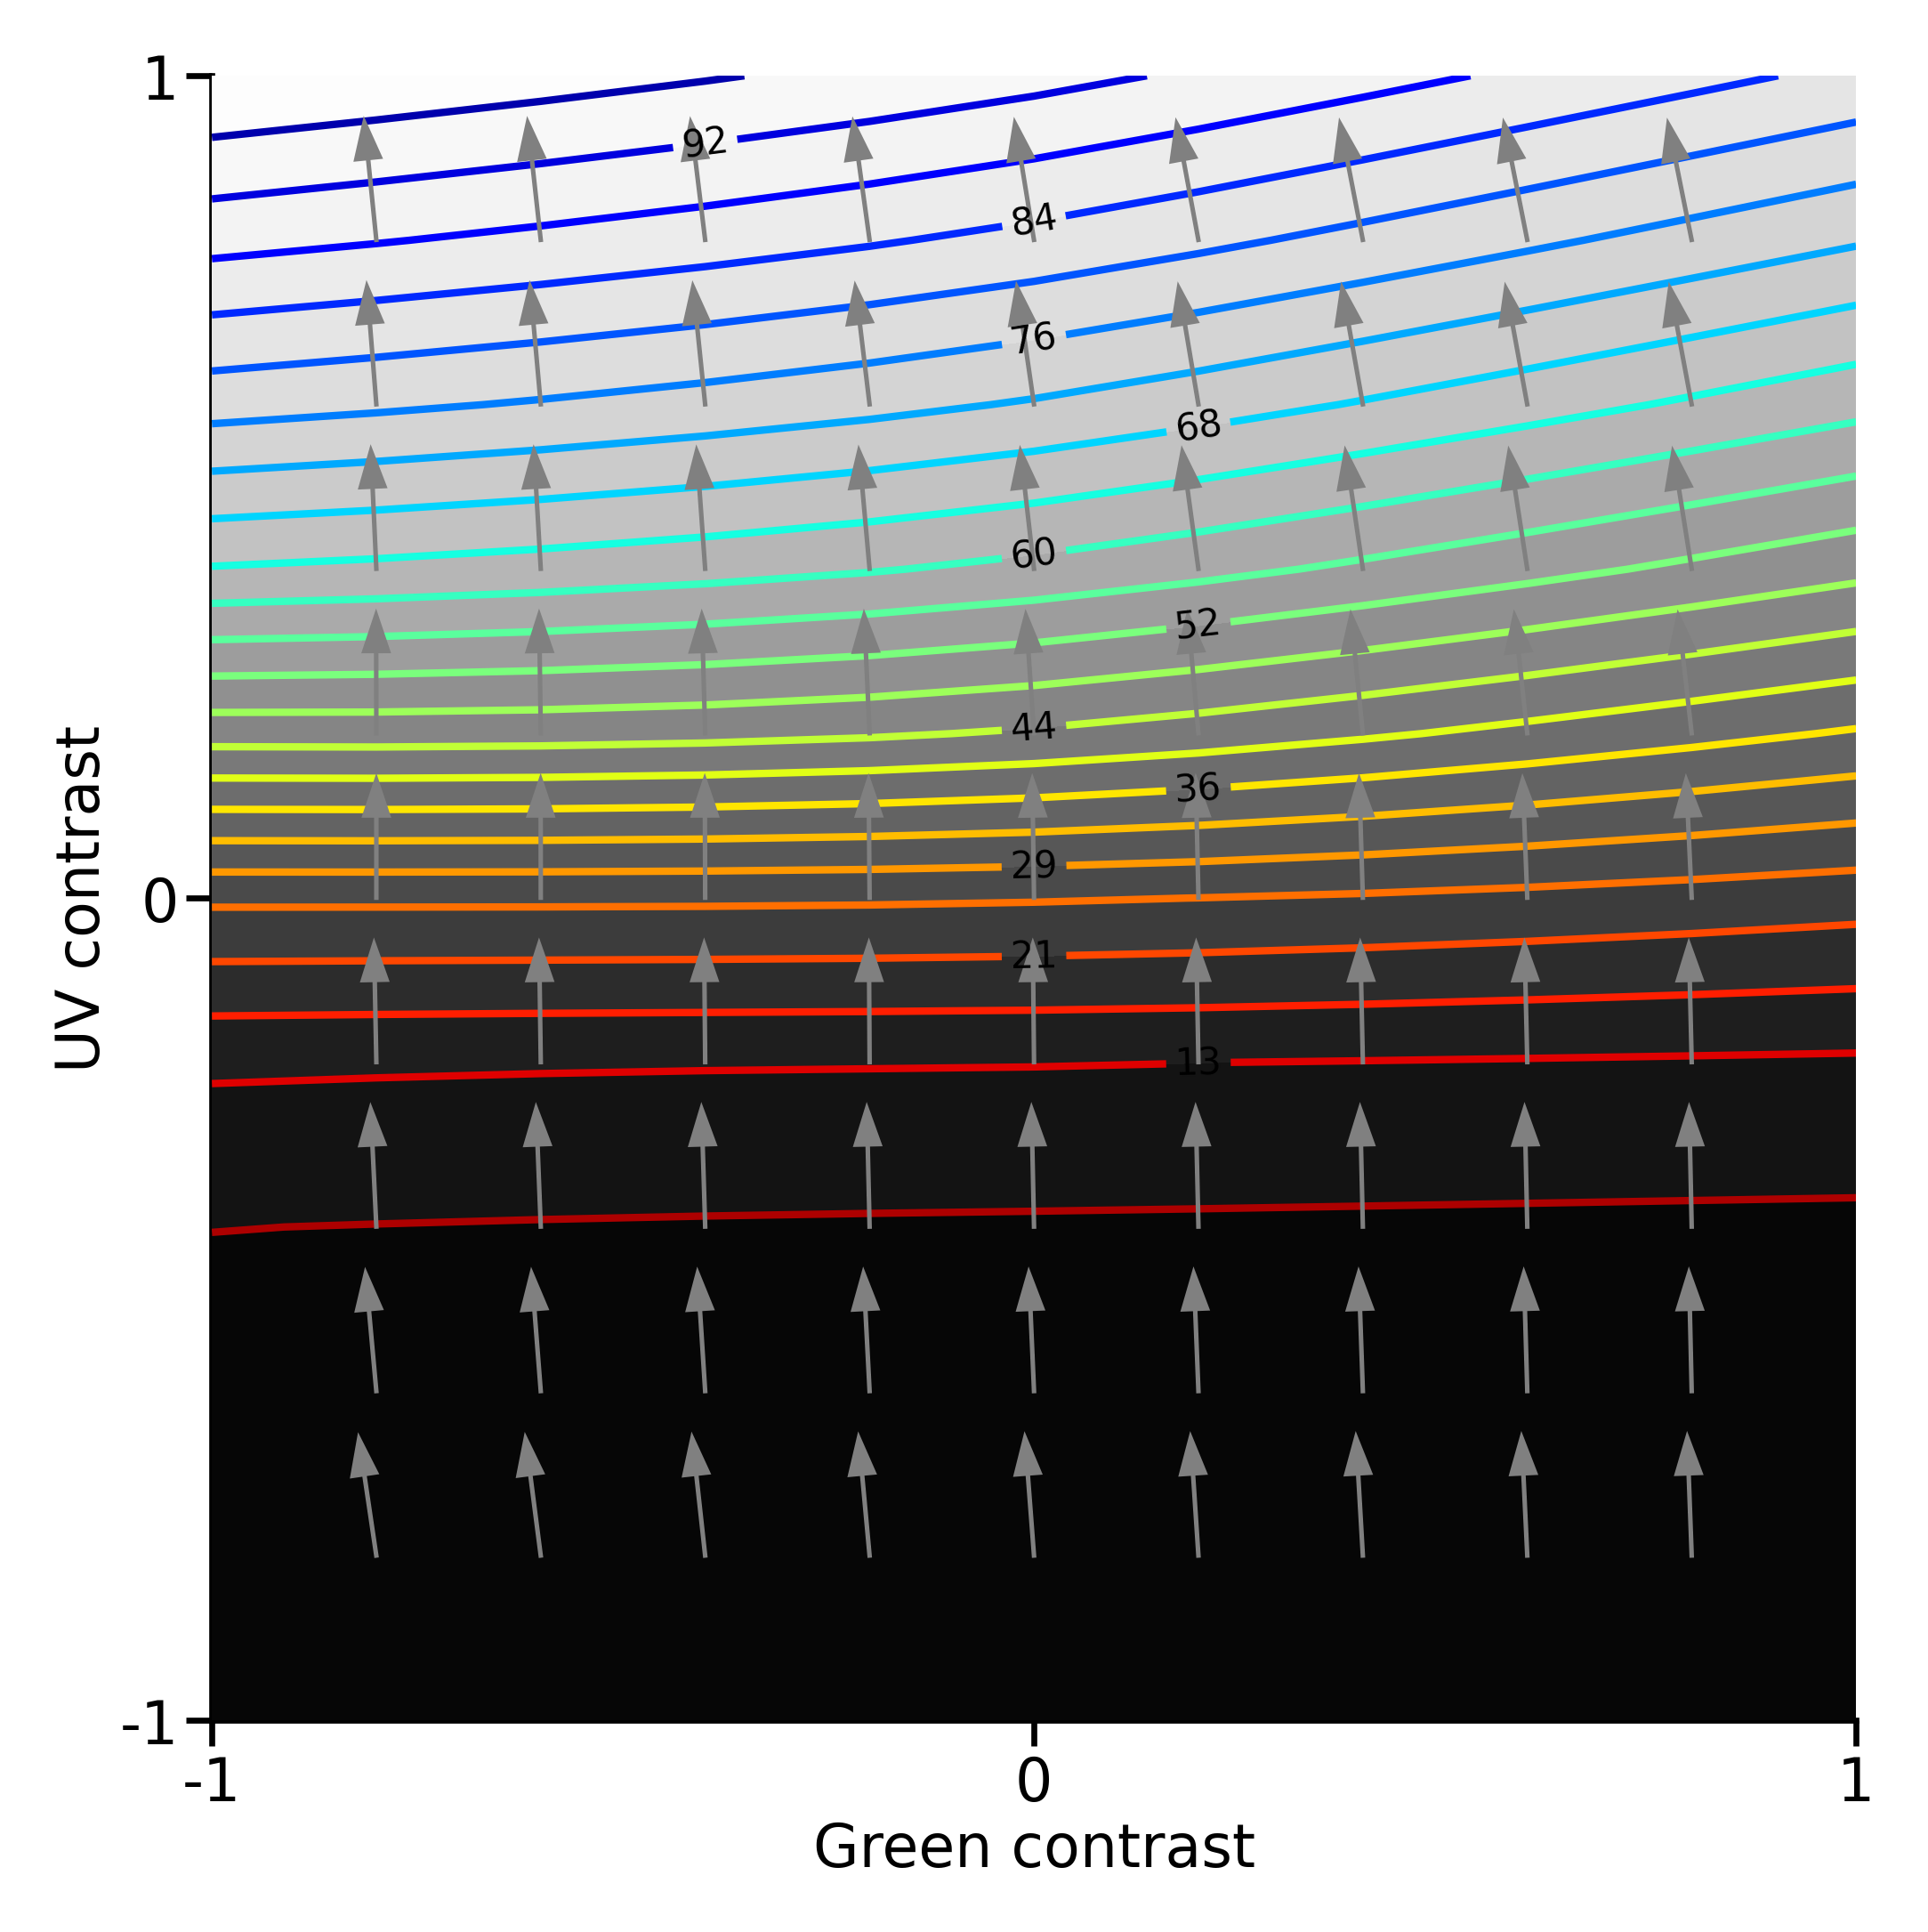

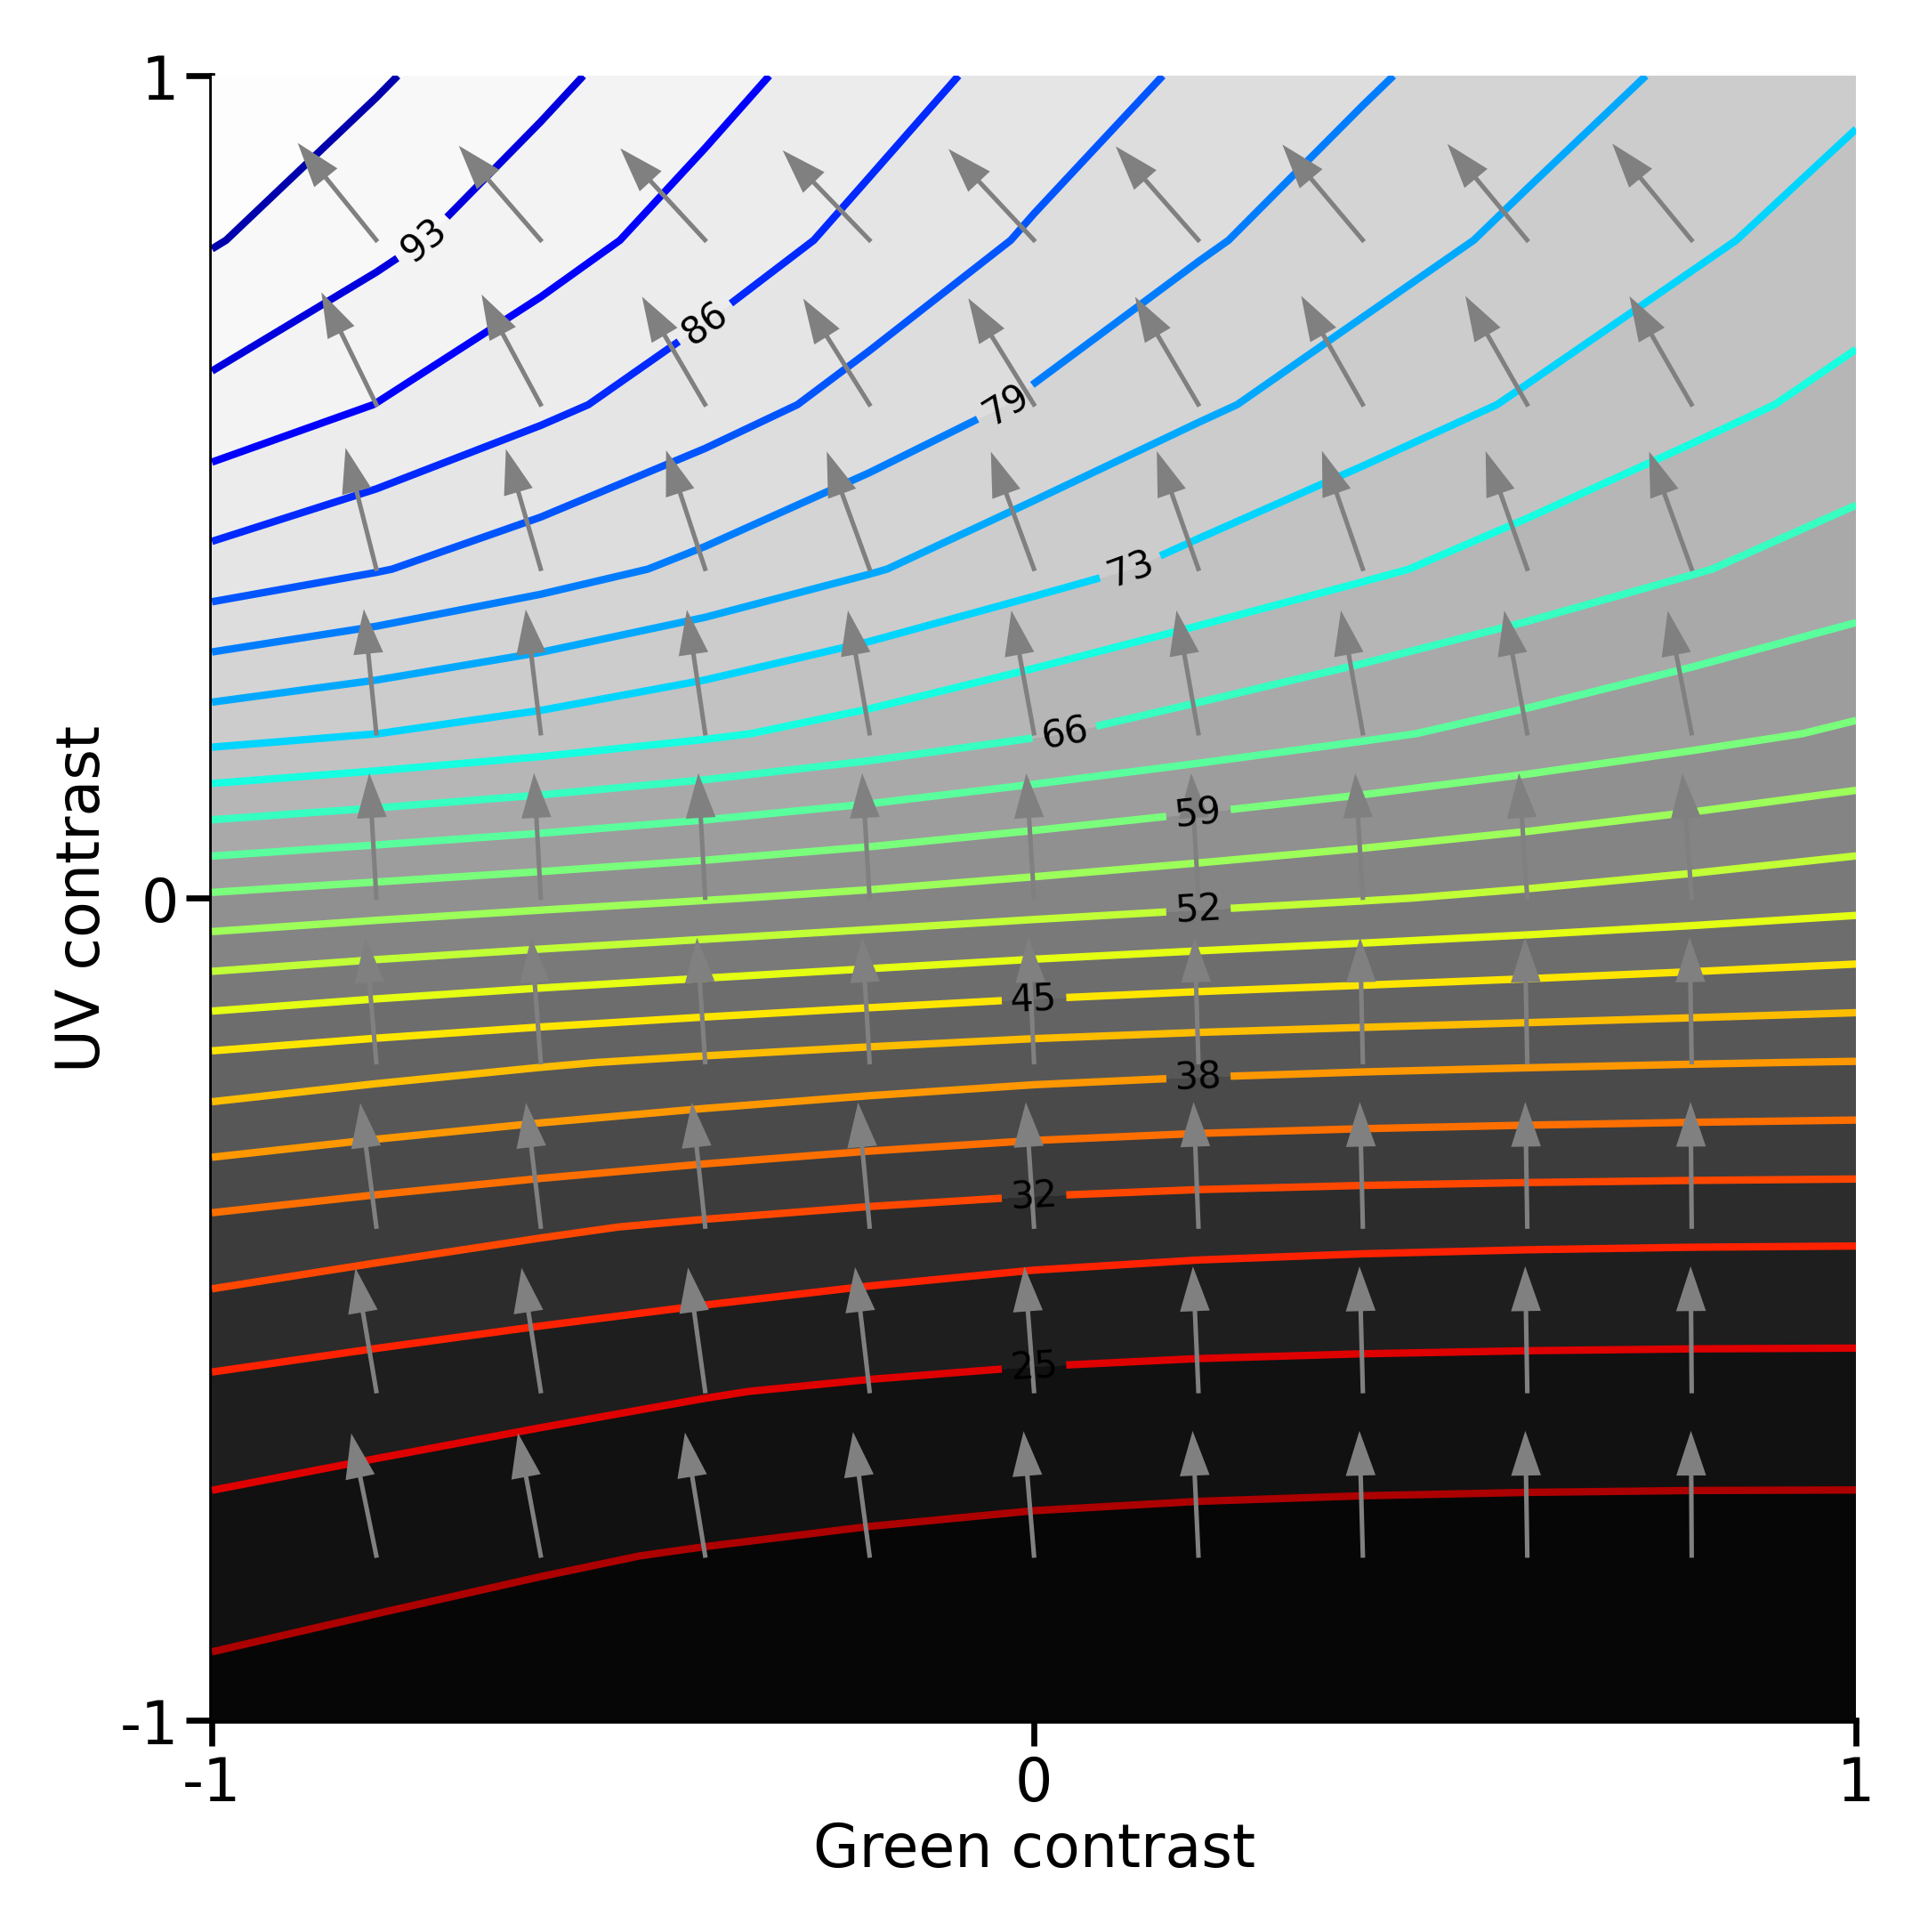

In [58]:
for neuron_id in example_cell_ids:
    orig_uv = df["center_temp_cont_uv"].loc[neuron_id]
    green_contrast_values = np.arange(-1, 1.2, .2)
    x = green_contrast_values#*orig_uv
    fig = plot_vector_field_resp_iso(x, x, norm_grid_dict_nonlin, gradient_grid_dict_nonlin, resp_grid_dict_nonlin,
                              neuron_id=neuron_id, normalize_response=True, cmap="Greys_r", rc_dict=rc_dict)
    save_this(fig_path, '_'.join([neuron_id, 'nonlin']), svg=False)
   #plt.close()

1.5656096184242014
100.0
0.15720671021081303
3.275900530859628
pdf
22.301199749970746
100.0
0.3772337513437657
0.9349197743823362
pdf


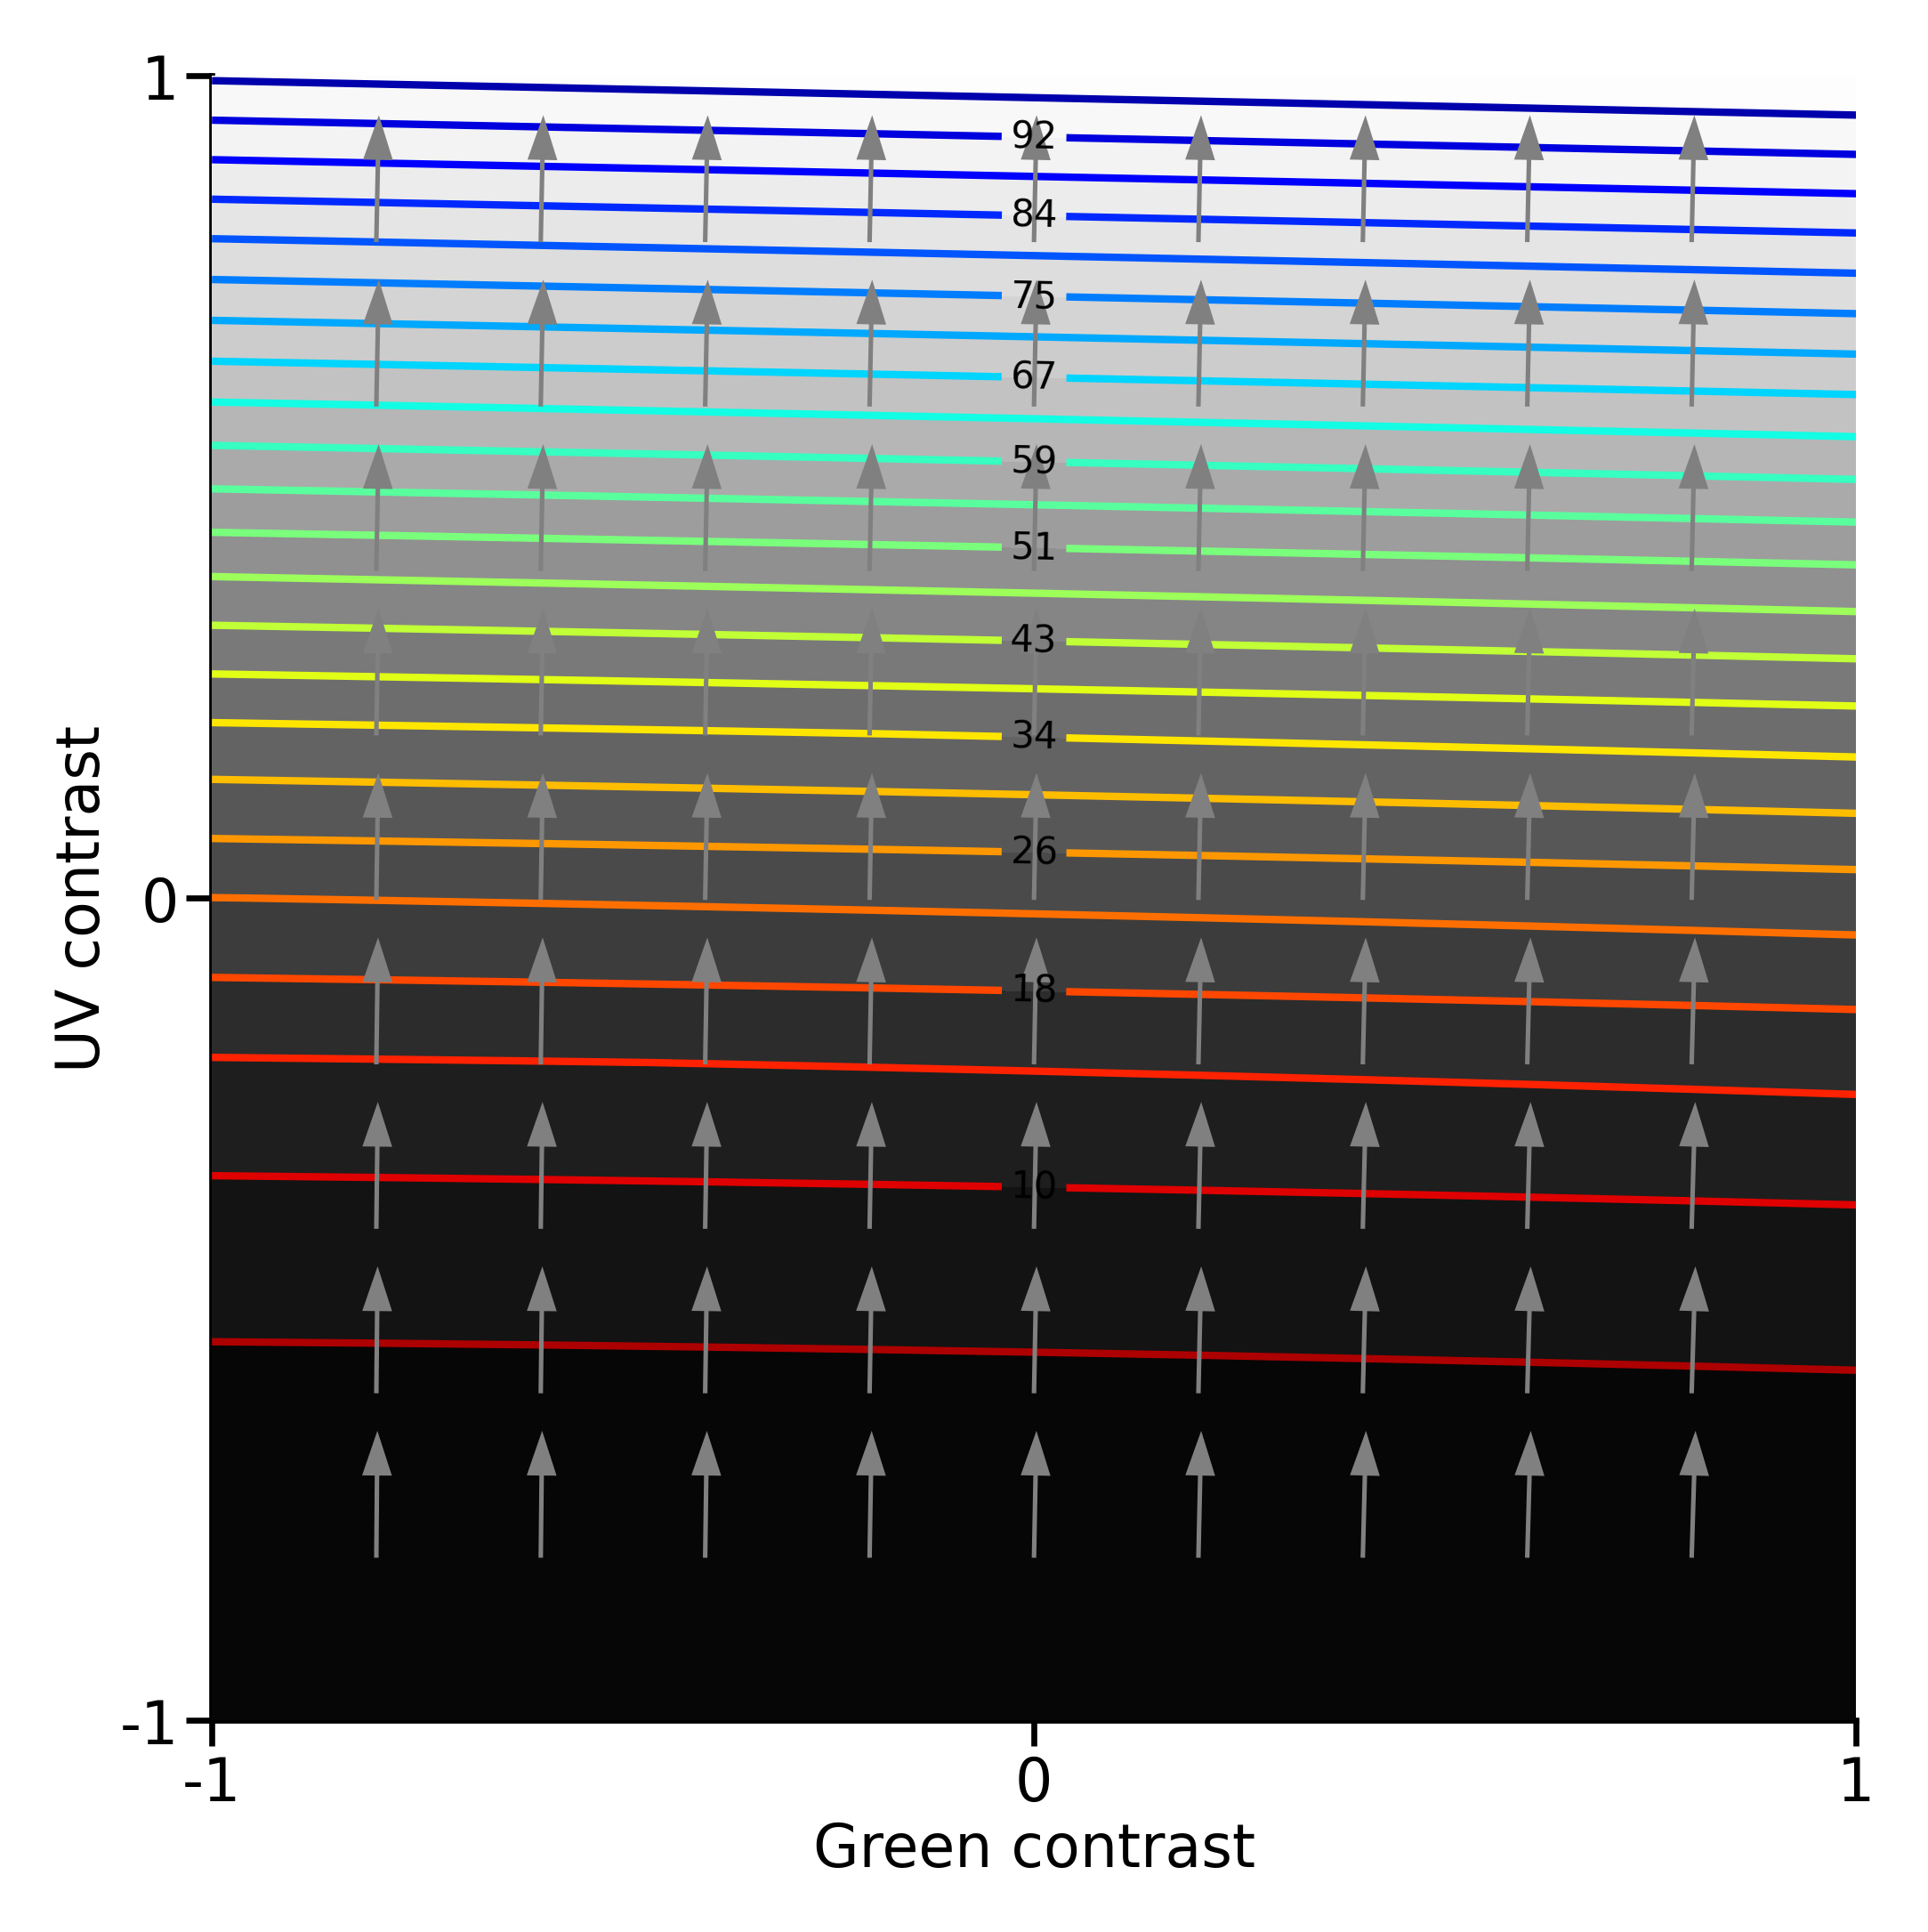

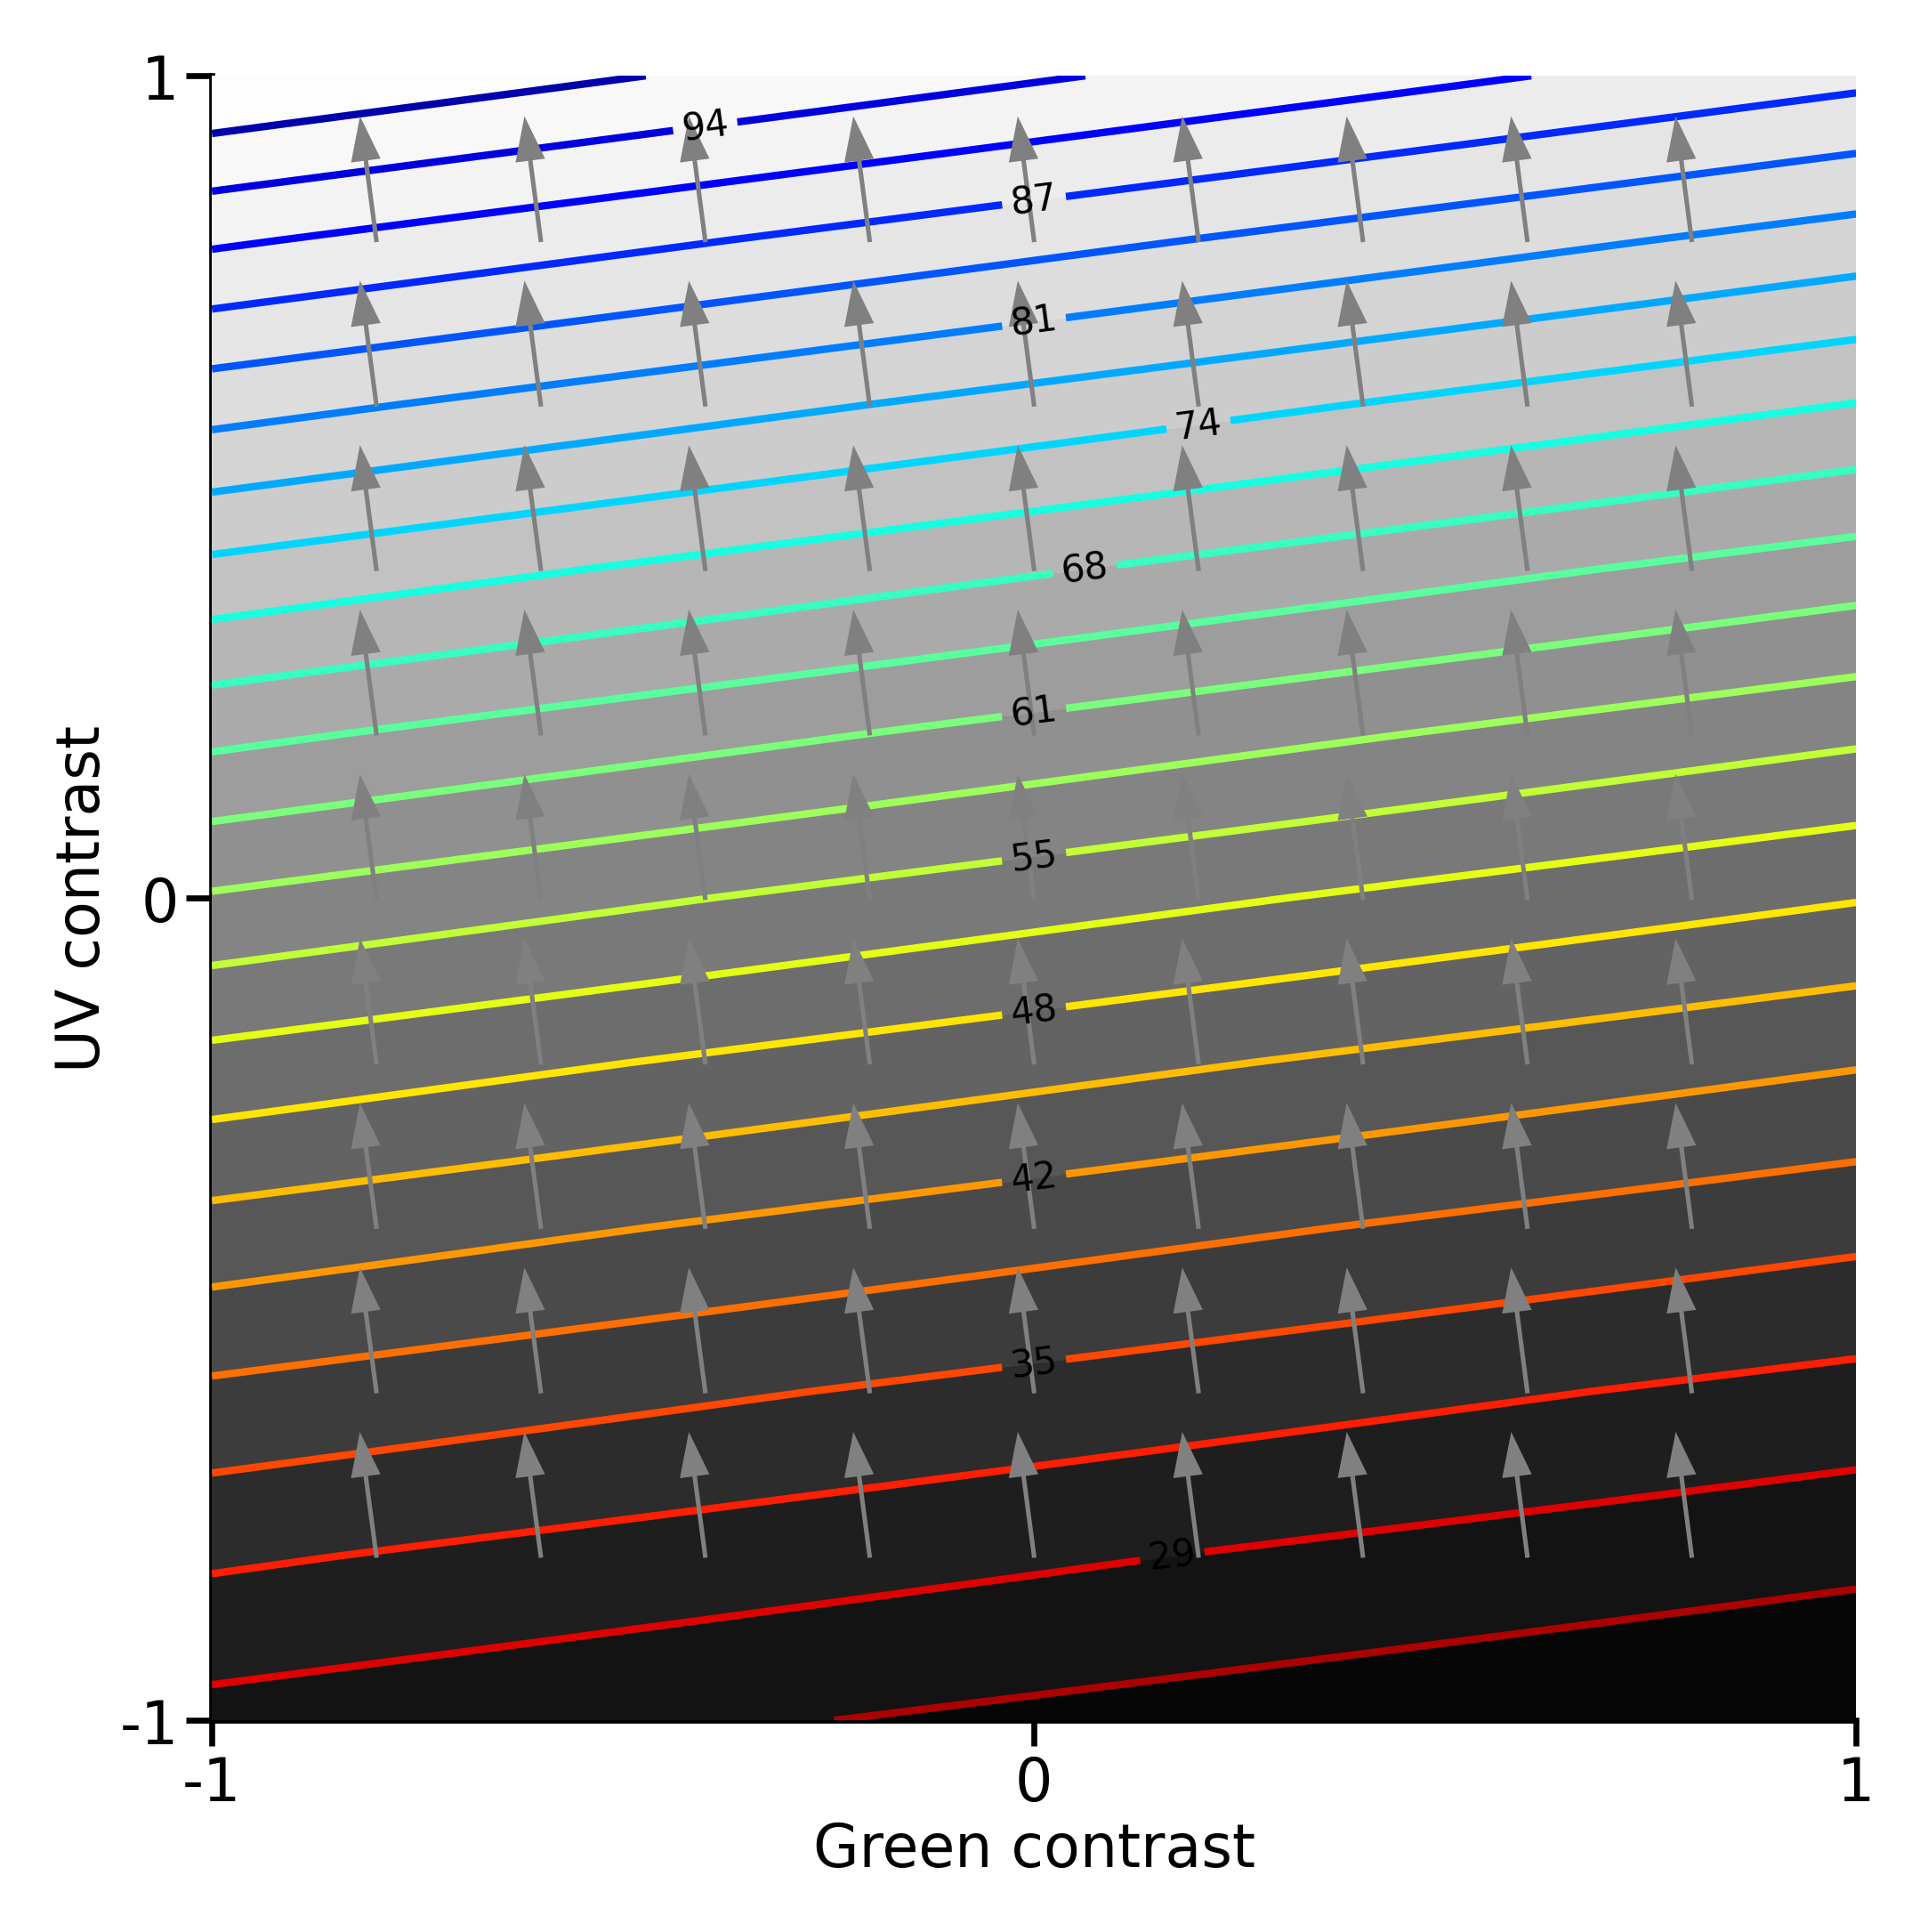

In [59]:
for neuron_id in example_cell_ids:
    orig_uv = df["center_temp_cont_uv"].loc[neuron_id]
    green_contrast_values = np.arange(-1, 1.2, .2)
    x = green_contrast_values#*orig_uv
    fig = plot_vector_field_resp_iso(x, x, norm_grid_dict_lin, gradient_grid_dict_lin, resp_grid_dict_lin,
                              neuron_id=neuron_id, normalize_response=True, cmap="Greys_r", rc_dict=rc_dict)
    save_this(fig_path, '_'.join([neuron_id, 'lin']), svg=False)
   #plt.close()

# plot response difference

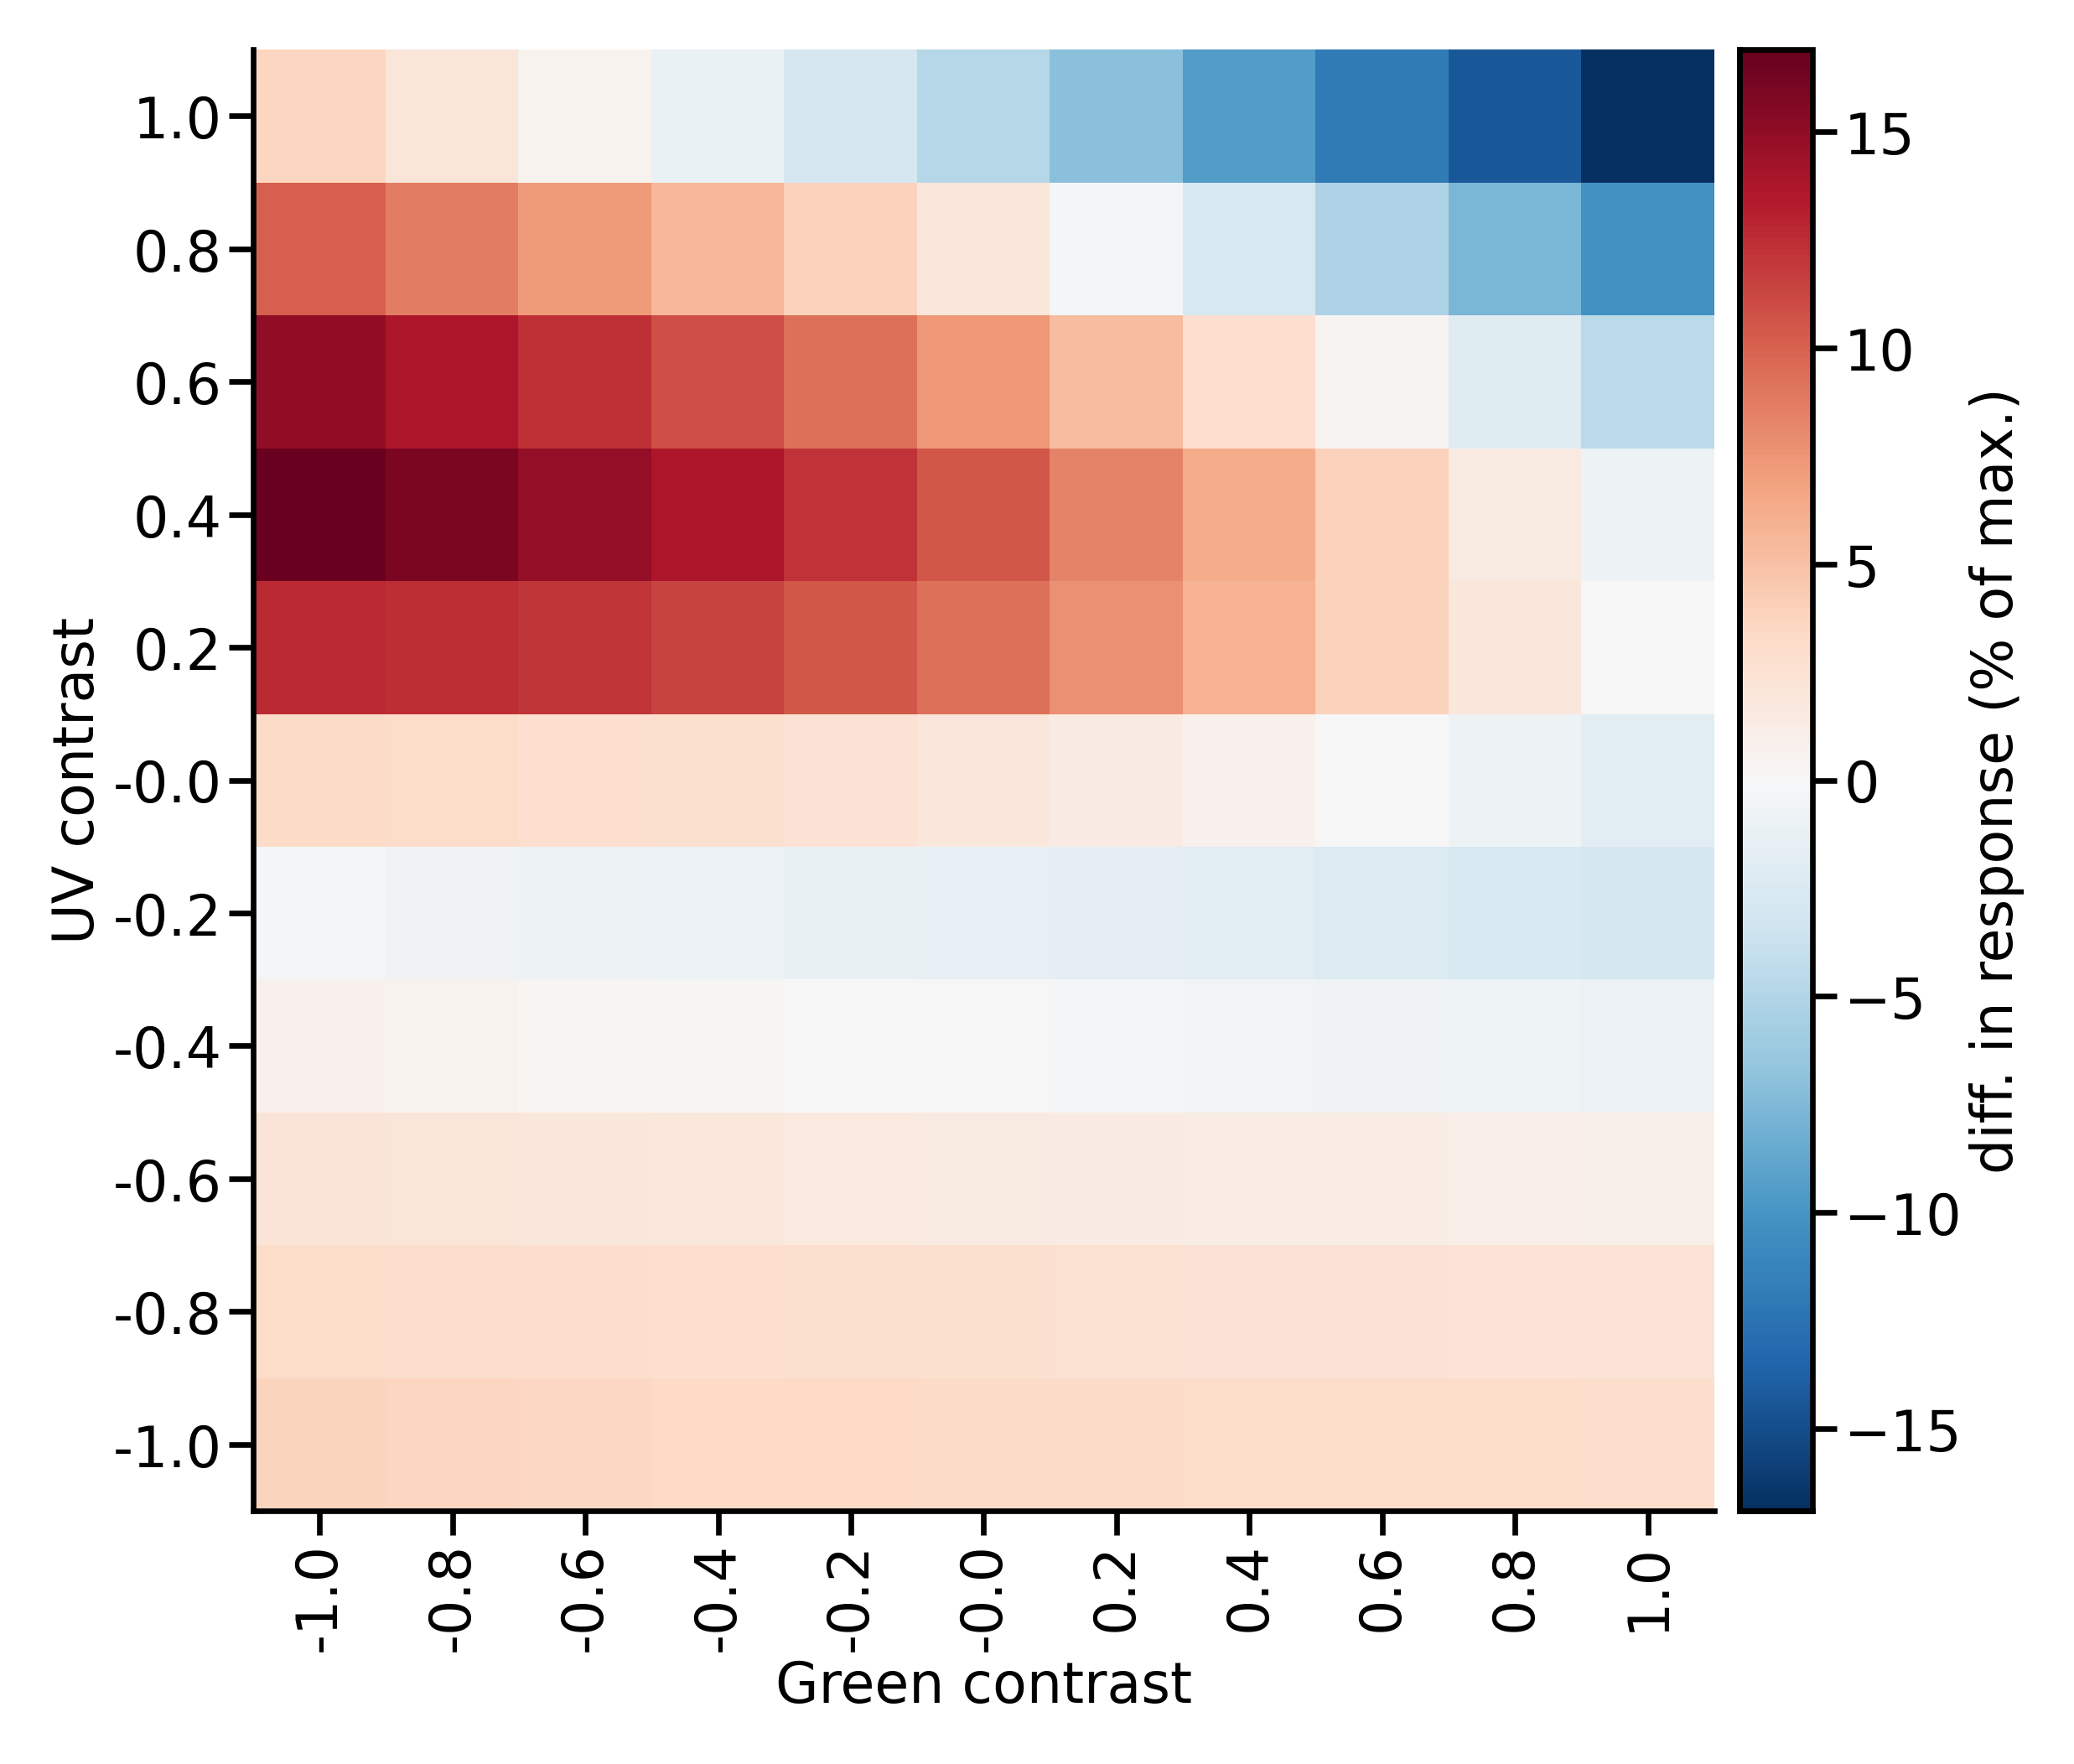

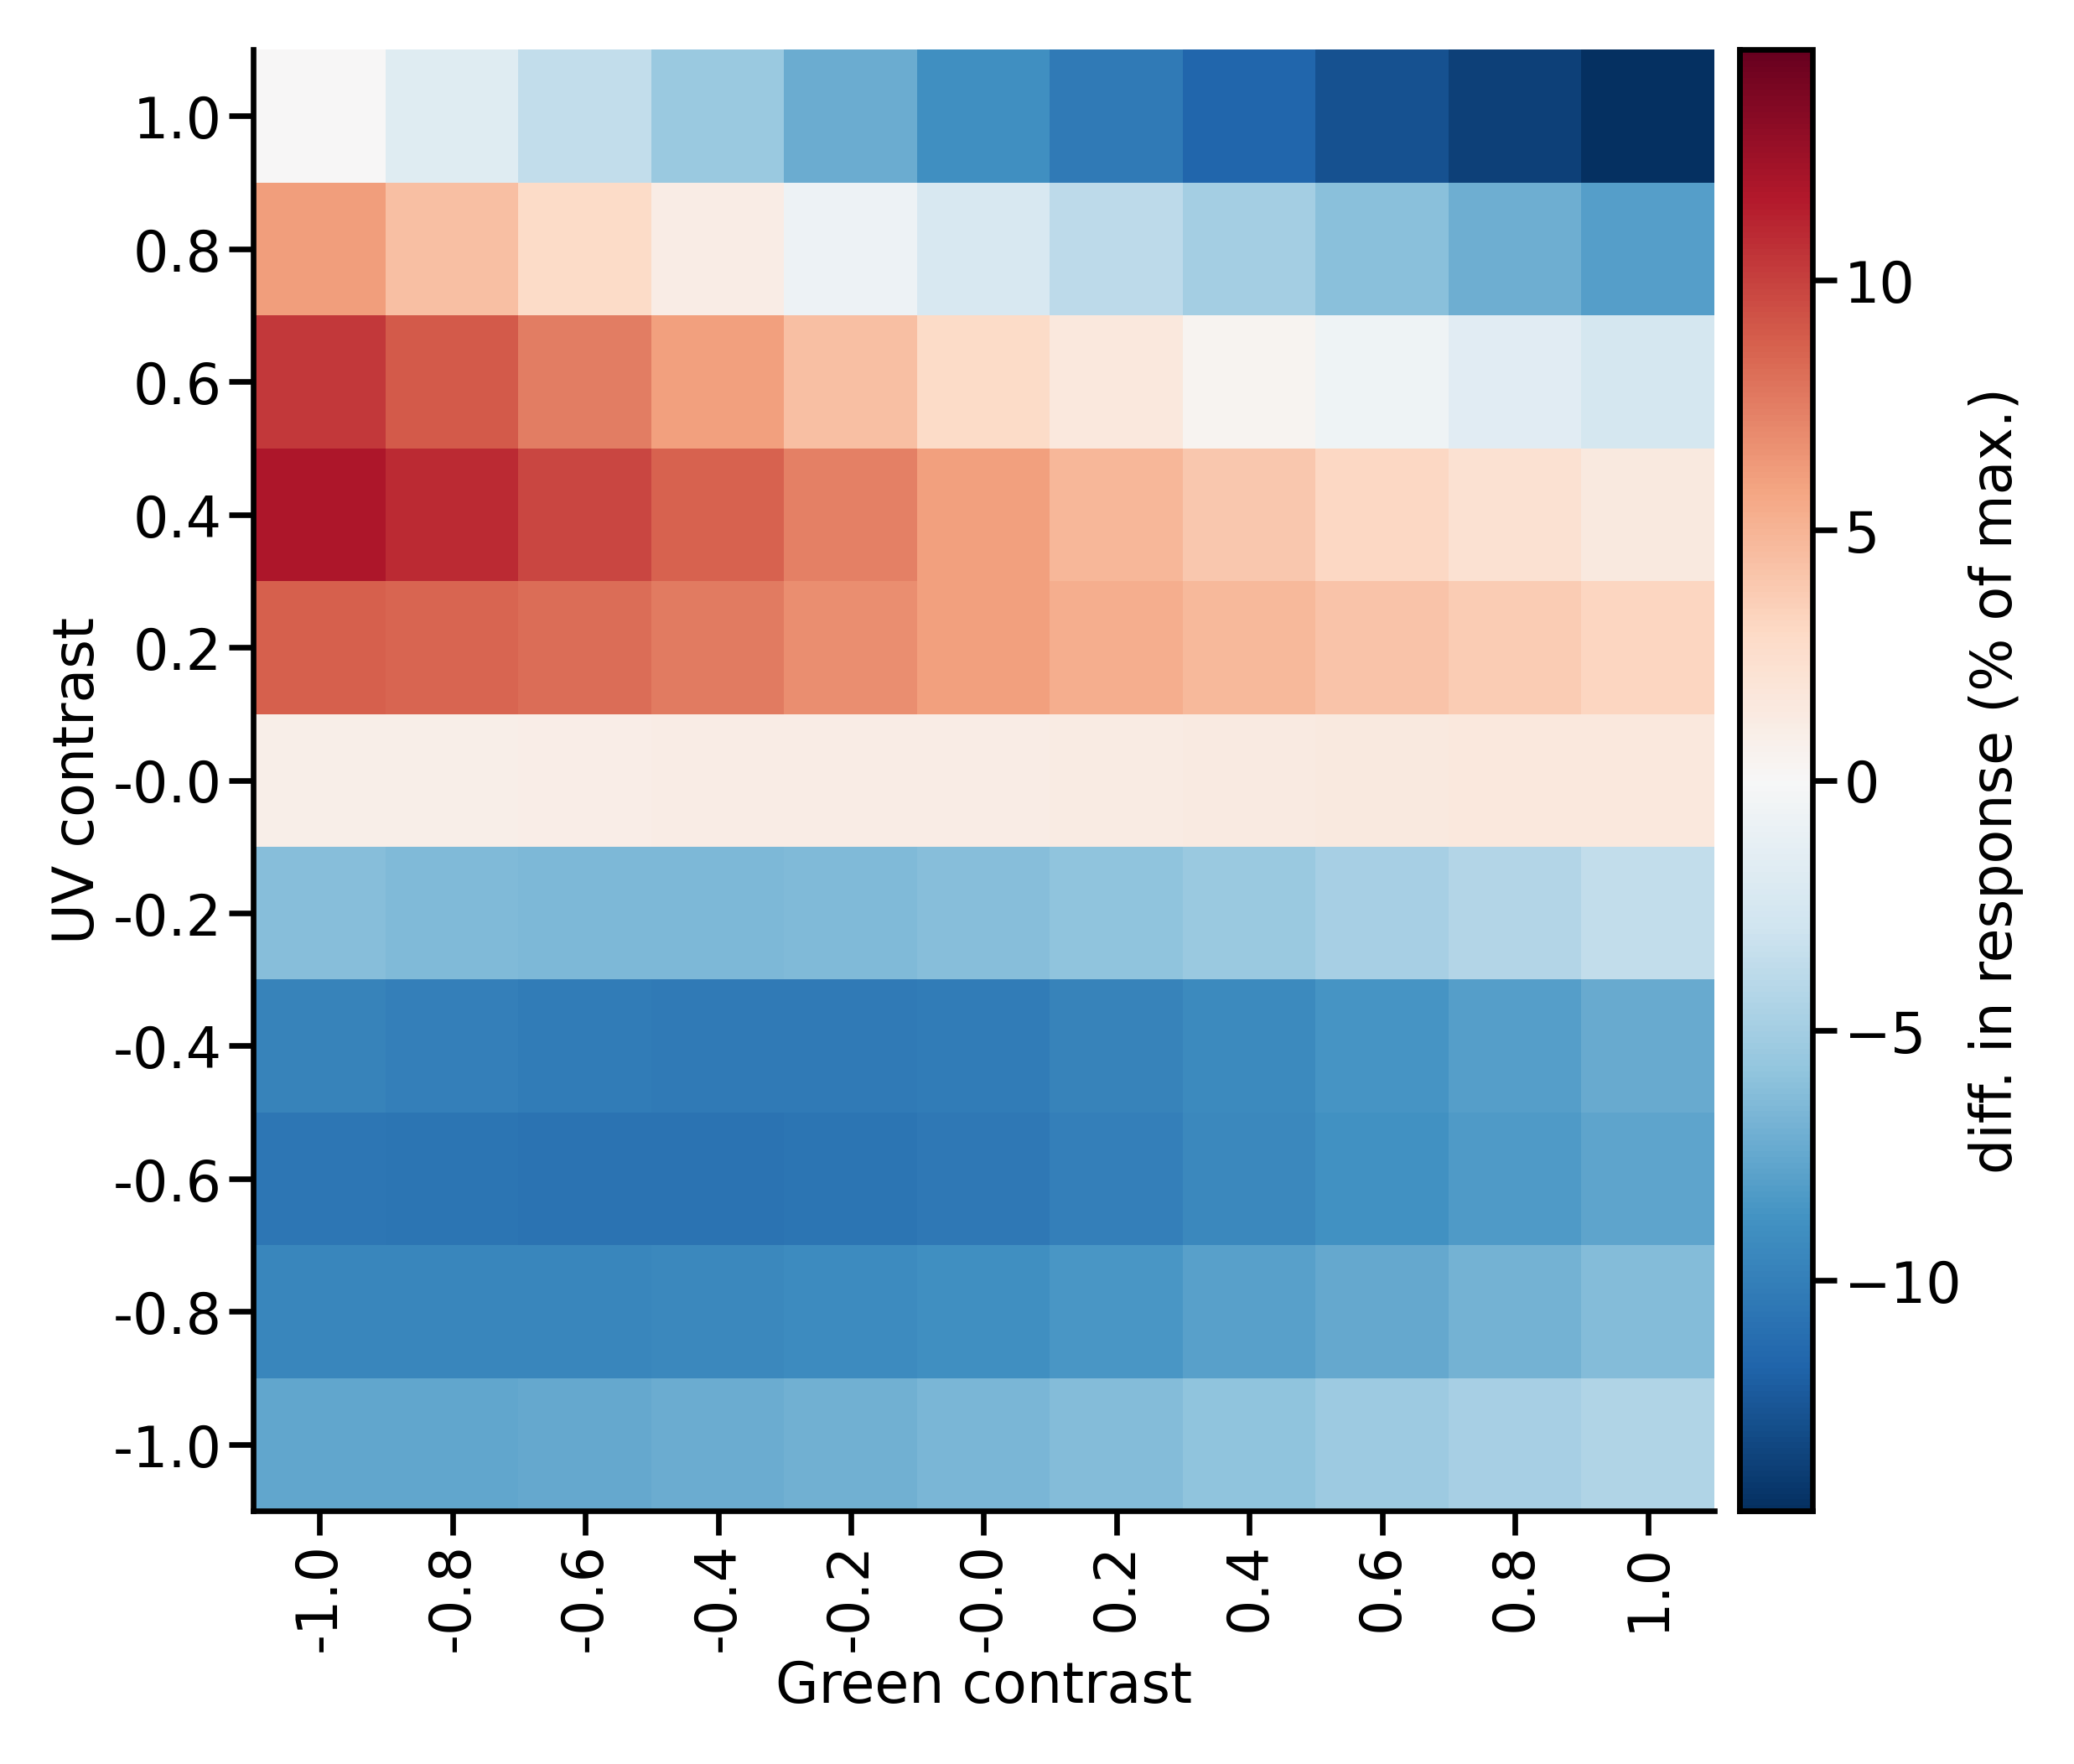

In [65]:

for neuron_id in example_cell_ids:
    plot_resp_diff(resp_grid_dict_nonlin, resp_grid_dict_lin,
                   neuron_id, green_contrast_values, 
                  rc_dict=rc_dict);